In [ ]:
import csv
import cv2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
images_path = "./gdrive/MyDrive/data/Unzipped images/images/"
annotations_path = "./gdrive/MyDrive/data/annotations/"
model_path = "./gdrive/MyDrive/models/effnetB2_mdl_wts.hdf5" 
IMG_SIZE = 260 ##300 for B3, 224 za B0 https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
BATCH_SIZE = 16

In [ ]:
def visualize_one_sample(image):
    plt.figure(figsize=(6, 4))
    image = np.array(image)
    plt.imshow(image, aspect='equal')
    current_axis = plt.gca()

    plt.show()

In [ ]:
def get_data(file_name):
  annotations = open(annotations_path + file_name)
  images = []
  labels = []
  
  ##brojac = 0 ##Maknuti kada treba ucitati sve podatke
  for row in csv.reader(annotations):
    ##if brojac == 10: ##Maknuti kada treba ucitati sve podatke
    ##  break          ##Maknuti kada treba ucitati sve podatke
    ##brojac += 1
    try:
      image = cv2.imread(images_path + row[0]) 
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      images.append(image)
      #Convert to one hot array
      if row[5]=="0":
        labels.append([1, 0]) ##Dodati koordinate ako treba bounding box
      else:
        labels.append([0, 1])
    except:
      print(images_path + row[0])
  annotations.close()
  visualize_one_sample(images[0])
  print(labels[:10])
  return np.array(images), np.array(labels)

In [ ]:
from tf.keras.applications.vgg19 import preprocess_input
def build_model():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  ##model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)
  model = EfficientNetB2(include_top=False, input_tensor=inputs, weights=None)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)
  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
  return model

./gdrive/MyDrive/data/Unzipped images/images/image_name


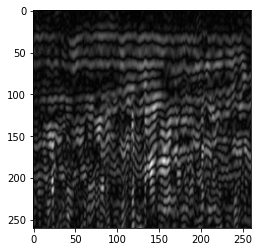

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0]]


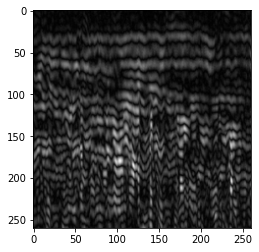

[[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0]]


In [ ]:
x, y = get_data("train_annotations.csv")
x_val, y_val = get_data("val_annotations.csv")

for i in range(20):
  store_x = open("./gdrive/MyDrive/data/pickle/x{number}.pkl".format(number=i), "wb")
  pickle.dump(x[i*len(x)//20:(i+1)*len(x)//20], store_x)
  store_x.close()

  store_y = open("./gdrive/MyDrive/data/pickle/y{number}.pkl".format(number=i), "wb")
  pickle.dump(y[i*len(y)//20:(i+1)*len(y)//20], store_y)
  store_y.close()

store_x_val = open("./gdrive/MyDrive/data/pickle/x_val.pkl", "wb")
pickle.dump(x_val, store_x_val)
store_x_val.close()

store_y_val = open("./gdrive/MyDrive/data/pickle/y_val.pkl", "wb")
pickle.dump(y_val, store_y_val)
store_y_val.close()

In [ ]:
store_x = open("./gdrive/MyDrive/data/pickle/x0.pkl", "rb")
x = pickle.load(store_x)
store_x.close()

store_y = open("./gdrive/MyDrive/data/pickle/y0.pkl", "rb")
y = pickle.load(store_y)
store_y.close()

for i in range(1, 20, 1):
  store_x = open("./gdrive/MyDrive/data/pickle/x{number}.pkl".format(number=i), "rb")
  data_slice = pickle.load(store_x)
  x = np.concatenate((x, data_slice))
  store_x.close()

  store_y = open("./gdrive/MyDrive/data/pickle/y{number}.pkl".format(number=i), "rb")
  data_slice = pickle.load(store_y)
  y = np.concatenate((y, data_slice))
  store_y.close()

store_x_val = open("./gdrive/MyDrive/data/pickle/x_val.pkl", "rb")
x_val = pickle.load(store_x_val)
store_x_val.close()

store_y_val = open("./gdrive/MyDrive/data/pickle/y_val.pkl", "rb")
y_val = pickle.load(store_y_val)
store_y_val.close()


In [ ]:
model = build_model()
epochs = 25
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
model.load_weights(model_path)  ##Ukljuciti ako zelimo nastaviti od zadnjeg treninga, iskljuciti ako zelimo poceti od nule
model.fit(x=x, y=y, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(x_val, y_val), verbose=1, callbacks=[model_checkpoint_callback]) ##Dodati checkpoint